In [15]:
import string 
import seaborn as sns
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import io

In [16]:
rstate=10

In [17]:
df = pd.read_csv(r"G:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT-CSE299-CYBERBULLYING PREVENTION-DETECTION and MENTAL COUNSELING SYSTEM\Machine Learning Models\Bengali hate speech.csv")


In [18]:
def remove_punctuation_from_sentence(sentence):
    sentence_without_punctuation="".join([c for c in sentence if c not in string.punctuation])
    return sentence_without_punctuation

In [19]:
df['sentence without punctuation'] = df['sentence'].apply(lambda x:remove_punctuation_from_sentence(x))


In [20]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits
from bnlp.corpus.util import remove_stopwords

In [21]:
basic_tokenizer = BasicTokenizer()
df['tokenized_sentence'] = df['sentence without punctuation'].apply(lambda x: basic_tokenizer.tokenize(x))
df.head()

,sentence,hate,category,sentence without punctuation,tokenized_sentence
0,যত্তসব পাপন শালার ফাজলামী!!!!!,1,sports,যত্তসব পাপন শালার ফাজলামী,"[যত্তসব, পাপন, শালার, ফাজলামী]"
1,পাপন শালা রে রিমান্ডে নেওয়া দরকার,1,sports,পাপন শালা রে রিমান্ডে নেওয়া দরকার,"[পাপন, শালা, রে, রিমান্ডে, নেওয়া, দরকার]"
2,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,1,sports,জিল্লুর রহমান স্যারের ছেলে এতো বড় জারজ হবে এটা...,"[জিল্লুর, রহমান, স্যারের, ছেলে, এতো, বড়, জারজ,..."
3,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,1,sports,শালা লুচ্চা দেখতে পাঠার মত দেখা যায়,"[শালা, লুচ্চা, দেখতে, পাঠার, মত, দেখা, যায়]"
4,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,1,sports,তুই তো শালা গাজা খাইছচ।তুর মার হেডায় খেলবে সাকিব,"[তুই, তো, শালা, গাজা, খাইছচ, ।, তুর, মার, হেডা..."


In [22]:
df['Removed Stopped word'] = df['sentence without punctuation'].apply(lambda x: remove_stopwords(x,stopwords))


In [23]:
df['hate_speech']=df['Removed Stopped word'].apply(' '.join)

In [24]:
x=df['hate_speech']
y=df['hate']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=rstate)

In [26]:
cv = CountVectorizer(stop_words = stopwords)
cv.fit(x)

# transform the training and testing data using count vectorizer object
X_train_count =  cv.transform(X_train)
X_test_count =  cv.transform(X_test)

#Tfid transformer
tfidf_tr = TfidfTransformer()
X_train_count_tfidf = tfidf_tr.fit_transform(X_train_count)
X_test_count_tfidf = tfidf_tr.transform(X_test_count)

# ngram level tf-idf 
tv_ngram = TfidfVectorizer(ngram_range=(1,2))
tv_ngram.fit(x)
X_train_tfidf_ngram =  tv_ngram.transform(X_train)
X_test_tfidf_ngram =  tv_ngram.transform(X_test)

In [27]:
def classifierModel(classifier, Xtrain, Ytrain, Xtest,roc):
    classifier.fit(Xtrain, Ytrain)
    predictions = classifier.predict(Xtest)
    print(30*'=')
    print(f"Accuracy : {accuracy_score(predictions, y_test)*float(100)}%")
    print(30*'=')
    if roc:
        probs = classifier.predict_proba(X_test_count_tfidf)
        preds = probs[:,1]
        fpr_svm, tpr_svm, threshold_svm = metrics.roc_curve(y_test, preds)
        roc_auc_svm = metrics.auc(fpr_svm, tpr_svm)

        import matplotlib.pyplot as plt
        plt.title(type(classifier).__name__)
        plt.plot(fpr_svm, tpr_svm, 'b', label = 'AUC = %0.2f' % roc_auc_svm)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    
    target_names = ['class 0', 'class 1']
    print(classification_report(y_test, predictions, target_names=target_names))



XGBOOST with Count Vectors: 
Accuracy : 72.96666666666667%


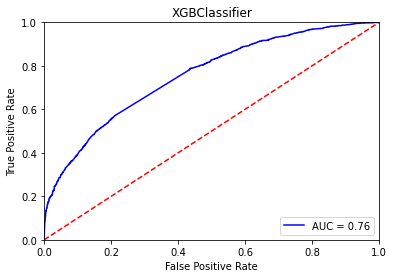

              precision    recall  f1-score   support

     class 0       0.73      0.95      0.82      3982
     class 1       0.75      0.29      0.42      2018

    accuracy                           0.73      6000
   macro avg       0.74      0.62      0.62      6000
weighted avg       0.73      0.73      0.69      6000


XGBOOST with Count Vectors + TF-IDF: 
Accuracy : 73.23333333333333%


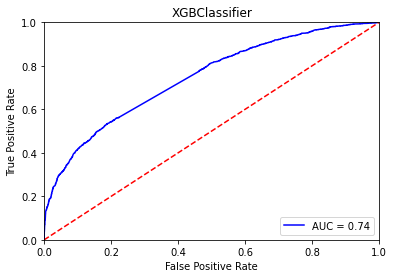

              precision    recall  f1-score   support

     class 0       0.73      0.94      0.82      3982
     class 1       0.74      0.32      0.45      2018

    accuracy                           0.73      6000
   macro avg       0.73      0.63      0.63      6000
weighted avg       0.73      0.73      0.70      6000


XGBOOST with N-Gram Vectors: 
Accuracy : 73.05%
              precision    recall  f1-score   support

     class 0       0.73      0.94      0.82      3982
     class 1       0.73      0.31      0.44      2018

    accuracy                           0.73      6000
   macro avg       0.73      0.63      0.63      6000
weighted avg       0.73      0.73      0.69      6000



In [28]:
from xgboost import XGBClassifier

print("\nXGBOOST with Count Vectors: ")
classifierModel(XGBClassifier(), X_train_count, y_train, X_test_count,roc=True)

print("\nXGBOOST with Count Vectors + TF-IDF: ")
classifierModel(XGBClassifier(), X_train_count_tfidf, y_train, X_test_count_tfidf,roc=True)

print("\nXGBOOST with N-Gram Vectors: ")
classifierModel(XGBClassifier(), X_train_tfidf_ngram, y_train, X_test_tfidf_ngram,roc=False)